# import 

In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate, \
BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda

from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import backend as K
import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from sklearn.metrics import mean_squared_error

import os
import sys
home=os.path.expanduser("~")
sys.path.append(os.path.join(home, 'station2grid'))

from tools.options import *
from models.station2code_model import ModelS2C
from models.station2gridSD_model import ModelS2GSD
from models.station2gridMD_model import ModelS2GMD
from tools import CommonObj, get_predict_result, plotMap
from tools.knn_model import KnnModel

os.environ["CUDA_VISIBLE_DEVICES"]='2' 

Using TensorFlow backend.


# model

In [2]:
isCode = 1
isConcat = 1
fea_num = 3
model_name='gan_test'
domain = 'sat'

In [3]:

class CGAN():
    def __init__(self, opt):
        # Input shape
        self.opt = opt
        
        if isCode==1:
            self.img_rows = 44
            self.img_cols = 26
            self.channels = 4
        else:
            self.img_rows = 348
            self.img_cols = 204
            self.channels = 1
        
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.setup()
        self.build_discriminator()
        self.build_generator()
        
        
    def setup(self):
        self.n_val_stations = len(self.opt.val_stations.split('_'))
        self.select_station_num = (77-self.n_val_stations)*fea_num
        
        dic = vars(self.opt)
        dic_join = [key+'-'+str(dic[key]) for key in dic]
        self.group = '--'.join(dic_join)
        self.weight_path = os.path.join(home,'station2grid','weights',self.group+'best-weight.hdf5')

        
    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        #model.summary()

        ############################################################
        if isConcat==1:
            noise = Input(shape=(self.latent_dim,)) # 100
            label = Input(shape=(self.select_station_num,)) # 76 
            label_embedding = Dense(self.latent_dim, activation='relu')(label) # 100
            x = Concatenate()([noise,  label_embedding]) # 100+100
            model_input = Dense(self.latent_dim, activation='relu')(x) # 100
        else:
            noise = Input(shape=(self.latent_dim,)) # 100
            label = Input(shape=(self.select_station_num,)) # 76
            label_embedding = Dense(self.latent_dim, activation='relu')(label) # 100
            model_input = multiply([noise, label_embedding]) # 100
        
        
        
        ############################################################
        img = model(model_input)
        
        g_input = [noise, label]
        g_output = img
        g = Model(g_input, g_output)
        return g

    def build_discriminator(self):
        model = Sequential(name='D') ###
        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()

        ############################################################
        
        if isConcat==1:
            img = Input(shape=self.img_shape)
            flat_img = Flatten()(img) # 4576
            label = Input(shape=(self.select_station_num,)) # 76
            label_embedding = Dense(np.prod(self.img_shape), activation='relu')(label)  # 4576
            x = Concatenate()([flat_img, label_embedding]) # 4576+4576
            model_input = Dense(np.prod(self.img_shape), activation='relu')(x) # 4576
        else: 
            img = Input(shape=self.img_shape) # (44,26,4)
            flat_img = Flatten()(img) # 4576
            label = Input(shape=(self.select_station_num,)) # 76
            label_embedding = Dense(np.prod(self.img_shape), activation='relu')(label)  # 4576
            model_input = multiply([flat_img, label_embedding]) # 4576

        ############################################################
        validity = model(model_input)
        
        d_input = [img, label]
        d_output = validity
        d = Model(d_input, d_output)
        return d
    
    def select_from_grid(self, input_arr, lats_lons):
        epas=[input_arr[:, lat, lon, :] for lat,lon in lats_lons]
        output_arr=K.concatenate(epas)
        return output_arr
    
    def train(self, X_train, Y_train, epochs, batch_size=128, sample_interval=50):
    #def train(self, lats_lons, X_train, Y_train, epochs, batch_size=128, sample_interval=50):
        
        # Configure input
        print('X_train.shape, y_train.shape', X_train.shape, Y_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        print('valid.shape, fake.shape', valid.shape, fake.shape)
        
        
        optimizer = Adam(0.0002, 0.5)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
        self.discriminator.summary() ###
        
        # Build the generator
        self.generator = self.build_generator()

        noise = Input(shape=(self.latent_dim,), name='noise_input')
        label = Input(shape=(self.select_station_num,), name='label_input')
        img_hat = self.generator([noise, label])
        self.generator.name = 'G' ###
        
        self.discriminator.trainable = False ###
        
        fake_ = self.discriminator([img_hat, label])
        self.discriminator.name = 'D_output' ###
        
        
        ###
        self.combined = Model(inputs=[noise, label], outputs=fake_)
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)
                
#         label_hat = Lambda(
#             self.select_from_grid, 
#             arguments={'lats_lons': lats_lons},
#             name='label_output'
#         )(img_hat)

#         self.combined = Model(inputs=[noise, label], outputs=[fake_, label_hat])
#         self.combined.compile(
#             loss={'D_output': 'binary_crossentropy', 'label_output': 'mean_squared_error'},
#             loss_weights={'D_output': 1., 'label_output': 0.2},
#             optimizer=optimizer
#         )
        self.combined.summary()
        ###

        
        
        df_history = pd.DataFrame()
        group = 'concat_%s-code_%s_feanum_%s'%(isConcat,isCode,fea_num)
        for epoch in range(epochs):

            # ---------------------------------------------------------------
            #  Train Discriminator
            # ---------------------------------------------------------------

            # Select a random half batch of images
            idxs = np.random.randint(0, len(X_train), batch_size)
            imgs, labels = X_train[idxs], Y_train[idxs]

            # Sample noise as generator input
            noise = np.random.normal(loc=0, scale=1, size=(batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            # discriminator here is trainable
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid) # [cross_entropy,acc]
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake) # [cross_entropy,acc]
            
            # calculate loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  
            
            
            
            # ---------------------------------------------------------------
            #  Train Generator
            # ---------------------------------------------------------------

            # Condition on labels
            idxs = np.random.randint(0, len(Y_train), batch_size)
            sampled_labels = Y_train[idxs]

            # Train the generator
            # discriminator in self.combined is not trainable
            
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)
#             ce_mse = self.combined.train_on_batch(
#                 x={'noise_input': noise, 'label_input': sampled_labels},
#                 y={'D_output': valid, 'label_output': sampled_labels}
#             )
#             g_loss, label_mse = ce_mse[0], ce_mse[1]

            
            
            
            # ---------------------------------------------------------------
            #  sample img
            # ---------------------------------------------------------------
            
            # Plot the progress
            if epoch % sample_interval == 0:
                self.generator.save(self.weight_path) 
                print('epoch = %d \t d_loss = %.3f \t acc = %.2f \t g_loss = %.3f'%(epoch, d_loss[0], d_loss[1], g_loss))
                #print('epoch = %d \t d_loss = %.3f \t acc = %.1f \t g_loss = %.3f \t mse = %.1f'%(epoch, d_loss[0], 100*d_loss[1], g_loss, label_mse))
                
                row = pd.DataFrame()
                row['group'] = [group]
                row['epoch'] = [epoch]
                row['d_loss'] = [d_loss[0]]
                row['d_acc'] = [d_loss[1]]
                row['g_loss'] = [g_loss]
                df_history = df_history.append(row)
                
                grid_test_norm = self.test(select_station_test)
                np.save('./temp/%s-epoch_%05d.npy'%(self.opt.model_name, epoch), grid_test_norm)
        df_history.to_csv('df_history.csv')
        
    def test(self, select_station_test):
        #print(self.weight_path)
        model_s2c = load_model(self.weight_path)
        noise = np.random.normal(loc=0, scale=1, size=(len(select_station_test), self.latent_dim))        
        code_test_norm = model_s2c.predict([noise, select_station_test])
        code_test_denorm = denormalize(code_test_norm, min_, max_)
        
        if isCode==1:
            grids_hat = modelS2GSD.c2g_model.predict(code_test_denorm)
            grids_hat = modelS2GSD.data.denormalize(grids_hat) 
        else:
            grids_hat = code_test_denorm
            
        return grids_hat #grids_hat
        

# option

In [4]:
class OptionGAN():
    def __init__(self, model_name='gan_concat_grid', features='pm25', val_stations='Chaozhou', 
                 domain='sat', k=3, weightKNN='distance', 
                 ae_type='code_length-4576'):
        
        self.model_name = model_name
        self.features = features
        self.val_stations = val_stations
        self.domain = domain
        self.k = k
        self.weightKNN = weightKNN
        self.ae_type = ae_type
        

In [5]:
val_stations='Tainan'

optionGAN = OptionGAN(
    model_name=model_name, 
    domain=domain, k=3, weightKNN='distance', 
    val_stations=val_stations, 
)


# data

In [6]:
if isCode==1:
    path = '/media/disk3/feynman52/station2grid/datasets/npy/%s/domain_%s-k_3-weightKNN_distance/code/code_length-4576/*code.npy'%(domain,domain)
    code_train_paths = sorted(glob(path))
    code_train = [np.load(path) for path in code_train_paths]
    code_train = np.concatenate(code_train, axis=0)
else:
    path = '/media/disk3/feynman52/station2grid/datasets/npy/%s/domain_%s-k_3-weightKNN_distance/grid/*grid.npy'%(domain,domain)
    code_train_paths = sorted(glob(path))
    code_train = [np.load(path) for path in code_train_paths]
    code_train = np.concatenate(code_train, axis=0)


In [7]:
path = '/media/disk3/feynman52/station2grid/datasets/npy/%s/domain_%s-k_3-weightKNN_distance/station/*_addmou_addfea.npy'%(domain,domain)
station_train_paths = sorted(glob(path))
station_train = [np.load(path)[:,:,] for path in station_train_paths]
station_train = np.concatenate(station_train, axis=0)
station_train.shape



(4383, 77, 22)

In [8]:
path = '/media/disk3/feynman52/station2grid/datasets/npy/epa/test_epa_addmou.npy'
station_test = np.load(path)
station_test.shape


(8760, 77, 19)

In [9]:
info = CommonObj().epa_station_info
valid_info = info[info.SiteEngName==optionGAN.val_stations]
train_info = info[info.SiteEngName!=optionGAN.val_stations]


select_station_train = station_train[:,train_info.index,:]
select_station_test = station_test[:,train_info.index,:] #station_test[[2000,4000,6000,8000],...][...,train_info.index]

select_station_train = select_station_train[:,:,[0,5,13]].reshape(4383,-1) #0,5,6,13,20,21
select_station_test = select_station_test[:,:,[0,2,10]].reshape(8760,-1) #0,2,3,10,17,18

select_station_train.shape, select_station_test.shape, 

((4383, 228), (8760, 228))

In [10]:
code_train.shape, select_station_train.shape, select_station_test.shape, 

((4383, 44, 26, 4), (4383, 228), (8760, 228))

# normalize

In [11]:
def normalize(A, min_, max_):
    eps = 1e-16
    B = (A-min_) / (max_-min_+eps) # 0~1
    C = (B-0.5) / 0.5 # -1~1
    return C

def denormalize(C, min_, max_):
    eps = 1e-16
    B = 0.5*C+0.5 
    A = B*(max_-min_+eps)+min_
    return A



In [12]:
min_ = np.min(code_train, axis=0)
max_ = np.max(code_train, axis=0)

code_train_norm = normalize(code_train, min_, max_)
code_train_norm.shape, min_.shape

((4383, 44, 26, 4), (44, 26, 4))

# train

In [13]:
optionS2GSD = OptionS2GSD(
    domain= domain, k= 3, weightKNN= 'distance',
    features='pm25',
    val_stations=val_stations,
    dnn_type='a1'
)

modelS2GSD = ModelS2GSD(optionS2GSD)

In [14]:
lats_lons = train_info[['row','col']].values
lats_lons.shape

(76, 2)

In [20]:
cgan = CGAN(optionGAN)
# cgan.train(code_train_norm, select_station_train, epochs=10000+1, batch_size=32, sample_interval=200)
# # cgan.train(lats_lons, code_train_norm, select_station_train, epochs=1000, batch_size=32, sample_interval=200)


# infer

In [24]:
grids_hat = cgan.test(select_station_test)

/media/disk3/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
grids_hat.shape

(8760, 348, 204, 1)

In [26]:
y_true = station_test[:,valid_info.index,0].reshape(-1)
y_hat = grids_hat[:, valid_info.row, valid_info.col, 0]
df = get_predict_result(y_true, y_hat, cgan.group, val_station_names=valid_info.SiteEngName)

In [27]:
mean_squared_error(df.predict, df.real)

120.0503175974528

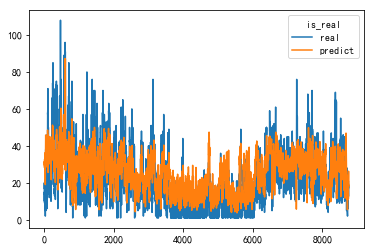

In [28]:
df.plot(y=['real','predict'])

In [29]:
# K.clear_session() 

# statistic

In [30]:
df_history = pd.read_csv('df_history.csv', index_col=0).reset_index(drop=True)
df_history.head(5)

,group,epoch,d_loss,d_acc,g_loss
0,concat_1-code_1_feanum_3,0,8.864159,0.187500,1.378358e-07
1,concat_1-code_1_feanum_3,200,0.677745,0.484375,2.282747e+00
2,concat_1-code_1_feanum_3,400,0.684558,0.593750,2.214939e+00
3,concat_1-code_1_feanum_3,600,0.603262,0.703125,1.258425e+00
4,concat_1-code_1_feanum_3,800,0.659000,0.562500,1.206489e+00


In [22]:
df_history.corr()

,epoch,d_loss,d_acc,g_loss
epoch,1.000000,-0.239179,0.189675,-0.162820
d_loss,-0.239179,1.000000,-0.668670,-0.419859
d_acc,0.189675,-0.668670,1.000000,0.169102
g_loss,-0.162820,-0.419859,0.169102,1.000000


(5, 50)

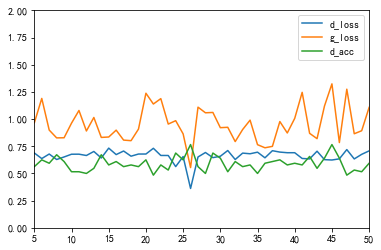

In [23]:
ax = df_history.plot(y=['d_loss','g_loss','d_acc'], )
ax.set_ylim(0, 2)
ax.set_xlim(5, 50)


In [ ]:
mse_list = []
for epoch in range(0,10000,200):
    path = './temp/gan_test-epoch_%05d.npy'%(epoch)
    grids_hat = np.load(path)
    
    y_true = station_test[:,valid_info.index,0].reshape(-1)
    y_hat = grids_hat[:, valid_info.row, valid_info.col, 0]
    
    df = get_predict_result(y_true, y_hat, cgan.group, val_station_names=valid_info.SiteEngName) 
    mse = mean_squared_error(df.predict, df.real)
    mse_list.append(mse)
    
    print(epoch, mse)
    

0 224.19513169029813
200 165.75548254862338
400 79.46053838676136
600 153.5925012262723
800 86.41131821559188
1000 115.73741630061507
1200 75.02242724700247
1400 85.85634878473772
1600 130.01781834165507
1800 72.12960370023568
2000 153.2824352822862
2200 62.45711869276688
2400 89.77984597755591
2600 118.65944404127933
2800 209.0738703330114
3000 109.7433545646524
3200 114.52098430096711
3400 70.88231420040897
3600 126.72182827300624
3800 104.67921189761181
4000 90.21707245620313
4200 141.03788143622398
4400 98.93463060137933
4600 84.3103682311954
4800 165.1731774613298
5000 122.2127377397755
5200 105.53271076057268
5400 128.47860651901783
5600 207.390456220714
5800 187.7756355835075
6000 120.81279052834148
6200 79.95854701426074


# repeat infer